#### PreDrill Estimation

It is common to make spatial predictions with uncertainty at an unsampled location.  This is done for the following purposes:

* predrill assessments to cross validate the current spatial model

* identification of the next locations sampling for information and subsurface resource recovery

This demonstration will help reinforce the practical implications of the choice of variogram model parameters.

#### Spatial Estimation

Consider the case of making an estimate at some unsampled location, $𝑧(\bf{u}_0)$, where $z$ is the property of interest (e.g. porosity etc.) and $𝐮_0$ is a location vector describing the unsampled location.

How would you do this given data, $𝑧(\bf{𝐮}_1)$, $𝑧(\bf{𝐮}_2)$, and $𝑧(\bf{𝐮}_3)$?

It would be natural to use a set of linear weights to formulate the estimator given the available data.

\begin{equation}
z^{*}(\bf{u}) = \sum^{n}_{\alpha = 1} \lambda_{\alpha} z(\bf{u}_{\alpha})
\end{equation}

We could add an unbiasedness constraint to impose the sum of the weights equal to one.  What we will do is assign the remainder of the weight (one minus the sum of weights) to the global average; therefore, if we have no informative data we will estimate with the global average of the property of interest.

\begin{equation}
z^{*}(\bf{u}) = \sum^{n}_{\alpha = 1} \lambda_{\alpha} z(\bf{u}_{\alpha}) + \left(1-\sum^{n}_{\alpha = 1} \lambda_{\alpha} \right) \overline{z}
\end{equation}

We will make a stationarity assumption, so let's assume that we are working with residuals, $y$. 

\begin{equation}
y^{*}(\bf{u}) = z^{*}(\bf{u}) - \overline{z}(\bf{u})
\end{equation}

If we substitute this form into our estimator the estimator simplifies, since the mean of the residual is zero.

\begin{equation}
y^{*}(\bf{u}) = \sum^{n}_{\alpha = 1} \lambda_{\alpha} y(\bf{u}_{\alpha})
\end{equation}

while satisfying the unbaisedness constraint.  

#### Kriging

Now the next question is what weights should we use?  

We could use equal weighting, $\lambda = \frac{1}{n}$, and the estimator would be the average of the local data applied for the spatial estimate. This would not be very informative.

We could assign weights considering the spatial context of the data and the estimate:

* **spatial continuity** as quantified by the variogram (and covariance function)
* **redundancy** the degree of spatial continuity between all of the available data with themselves 
* **closeness** the degree of spatial continuity between the avaiable data and the estimation location

The kriging approach accomplishes this, calculating the best linear unbiased weights for the local data to estimate at the unknown location.  The derivation of the kriging system and the resulting linear set of equations is available in the lecture notes.  Furthermore kriging provides a measure of the accuracy of the estimate!  This is the kriging estimation variance (sometimes just called the kriging variance).

\begin{equation}
\sigma^{2}_{E}(\bf{u}) = C(0) - \sum^{n}_{\alpha = 1} \lambda_{\alpha} C(\bf{u}_0 - \bf{u}_{\alpha})
\end{equation}

What is 'best' about this estimate? Kriging estimates are best in that they minimize the above estimation variance. 

#### Properties of Kriging

Here are some important properties of kriging:

* **Exact interpolator** - kriging estimates with the data values at the data locations
* **Kriging variance** can be calculated before getting the sample information, as the kriging estimation variance is not dependent on the values of the data nor the kriging estimate, i.e. the kriging estimator is homoscedastic. 
* **Spatial context** - kriging takes into account, furthermore to the statements on spatial continuity, closeness and redundancy we can state that kriging accounts for the configuration of the data and structural continuity of the variable being estimated.
* **Scale** - kriging may be generalized to account for the support volume of the data and estimate. We will cover this later.
* **Multivariate** - kriging may be generalized to account for multiple secondary data in the spatial estimate with the cokriging system. We will cover this later.
* **Smoothing effect** of kriging can be forecast. We will use this to build stochastic simulations later.

#### Spatial Continuity 

**Spatial Continuity** is the correlation between values over distance.

* No spatial continuity – no correlation between values over distance, random values at each location in space regardless of separation distance.

* Homogenous phenomenon have perfect spatial continuity, since all values as the same (or very similar) they are correlated. 

We need a statistic to quantify spatial continuity! A convenient method is the Semivariogram.

#### The Semivariogram

Function of difference over distance.

* The expected (average) squared difference between values separated by a lag distance vector (distance and direction), $h$:

\begin{equation}
\gamma(\bf{h}) = \frac{1}{2 N(\bf{h})} \sum^{N(\bf{h})}_{\alpha=1} (z(\bf{u}_\alpha) - z(\bf{u}_\alpha + \bf{h}))^2  
\end{equation}

where $z(\bf{u}_\alpha)$ and $z(\bf{u}_\alpha + \bf{h})$ are the spatial sample values at tail and head locations of the lag vector respectively.

* Calculated over a suite of lag distances to obtain a continuous function.

* the $\frac{1}{2}$ term converts a variogram into a semivariogram, but in practice the term variogram is used instead of semivariogram.
* We prefer the semivariogram because it relates directly to the covariance function, $C_x(\bf{h})$ and univariate variance, $\sigma^2_x$:

\begin{equation}
C_x(\bf{h}) = \sigma^2_x - \gamma(\bf{h})
\end{equation}

Note the correlogram is related to the covariance function as:

\begin{equation}
\rho_x(\bf{h}) = \frac{C_x(\bf{h})}{\sigma^2_x}
\end{equation}

The correlogram provides of function of the $\bf{h}-\bf{h}$ scatter plot correlation vs. lag offset $\bf{h}$.  

\begin{equation}
-1.0 \le \rho_x(\bf{h}) \le 1.0
\end{equation}

#### Load the required libraries

The following code loads the required libraries.

In [1]:
import geostatspy.GSLIB as GSLIB                       # GSLIB utilies, visualization and wrapper
import geostatspy.geostats as geostats                 # GSLIB methods convert to Python    

We will also need some standard packages. These should have been installed with Anaconda 3.

In [2]:
%matplotlib inline
import os                                               # to set current working directory 
import sys                                              # supress output to screen for interactive variogram modeling
import io
import numpy as np                                      # arrays and matrix math
import pandas as pd                                     # DataFrames
import matplotlib.pyplot as plt                         # plotting
from matplotlib.pyplot import cm                        # color maps
from matplotlib.patches import Ellipse                  # plot an ellipse
import math                                             # sqrt operator
from scipy.stats import norm
from ipywidgets import interactive                      # widgets and interactivity
from ipywidgets import widgets                            
from ipywidgets import Layout
from ipywidgets import Label
from ipywidgets import VBox, HBox
from intake import cat

/opt/tljh/user/lib/python3.7/site-packages/intake/source/discovery.py:137: FutureWarning: The drivers ['sql_cat', 'sql', 'sql_auto', 'sql_manual'] do not specify entry_points and were only discovered via a package scan. This may break in a future release of intake. The packages should be updated.
  FutureWarning)


If you get a package import error, you may have to first install some of these packages. This can usually be accomplished by opening up a command window on Windows and then typing 'python -m pip install [package-name]'. More assistance is available with the respective package docs.  

#### Loading Tabular Data

Here's the command to load our comma delimited data file in to a Pandas' DataFrame object.

In [3]:
df = cat.sample_data_MV_biased.read()           # read a .csv file in as a DataFrame
df = df.sample(frac = 0.2,random_state=73073)
#print(df.iloc[0:5,:])                                  # display first 4 samples in the table as a preview
df.head()                                               # we could also use this command for a table preview 

,Unnamed: 0,X,Y,Facies,Porosity,Perm,AI
138,223,280.0,409.0,1.0,0.136716,17.126888,4728.067903
132,215,230.0,749.0,1.0,0.204587,1665.384124,3994.709069
14,22,300.0,500.0,1.0,0.159891,105.797436,3658.811458
198,326,620.0,389.0,0.0,0.100296,7.578784,6397.384419
207,341,370.0,689.0,1.0,0.142434,218.419949,5072.154879


We will work with all facies pooled together. I wanted to simplify this workflow and focus more on spatial continuity direction detection. Finally, by not using facies we do have more samples to support our statistical inference. Most often facies are essential in the subsurface model. Don't worry we will check if this is reasonable in a bit.   

You are welcome to repeat this workflow on a by-facies basis.  The following code could be used to build DataFrames ('df_sand' and 'df_shale') for each facies.

```p
df_sand = pd.DataFrame.copy(df[df['Facies'] == 1]).reset_index()  # copy only 'Facies' = sand records
df_shale = pd.DataFrame.copy(df[df['Facies'] == 0]).reset_index() # copy only 'Facies' = shale records
```

Let's look at summary statistics for all facies combined:

In [4]:
df.describe().transpose()                               # summary table of sand only DataFrame statistics

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,74.0,311.608108,159.933789,9.000000,209.500000,319.000000,437.000000,571.000000
X,74.0,471.891892,282.603724,0.000000,232.500000,405.000000,765.000000,990.000000
Y,74.0,489.932432,291.512933,9.000000,224.000000,484.500000,729.000000,999.000000
Facies,74.0,0.594595,0.494322,0.000000,0.000000,1.000000,1.000000,1.000000
Porosity,74.0,0.125834,0.031093,0.062169,0.102895,0.126264,0.148840,0.204587
Perm,74.0,73.040451,214.164084,0.300430,2.081215,10.385010,50.841029,1665.384124
AI,74.0,4853.532434,1100.612966,1981.177309,4074.882537,4722.574276,5542.402947,7561.250336


Let's pick some min and max values for the color bars on our plots.

In [5]:
pormin = 0.06; pormax = 0.18
permmin = 0.0; permmax = 1500.0
poravg = np.average(df['Porosity'].values)
porvar = np.var(df['Porosity'].values)

#### Inspection of Posted Data

Data visualization is very useful to detect patterns. Our brains are very good at pattern detection. I promote quantitative methods and recognize issues with cognitive bias, but it is important to recognize the value is expert intepretation based on data visualization.

* This data visualization will also be important to assist with parameter selection for the quantitative methods later.

Let's plot the location maps of normal score transforms of porosity and permeability for all facies. We will also include a cross plot of the nscore permeability vs. porosity colored by facies to aid with comparison in spatial features between the porosity and permeability data.

/opt/tljh/user/lib/python3.7/site-packages/geostatspy/GSLIB.py:336: MatplotlibDeprecationWarning: The 'verts' parameter of scatter() is deprecated since Matplotlib 3.2 and will be removed two minor releases later.  If any parameter follows 'verts', they should be pass as keyword, not positionally.
  edgecolors="black",


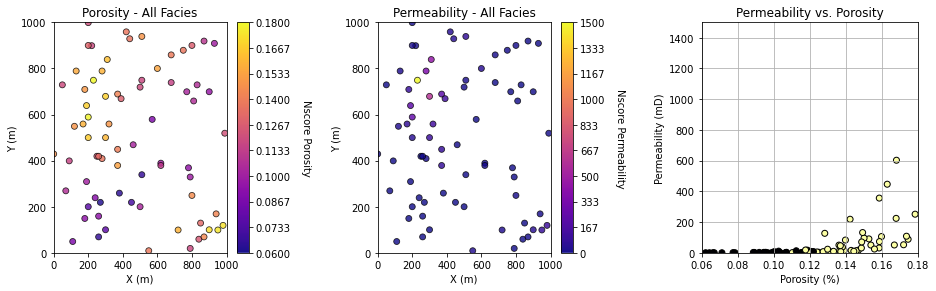

In [6]:
cmap = plt.cm.plasma                                    # set the color map
plt.subplot(131)                                        # location map of normal score transform of porosity
GSLIB.locmap_st(df,'X','Y','Porosity',0,1000,0,1000,pormin,pormax,'Porosity - All Facies','X (m)','Y (m)','Nscore Porosity',cmap)

plt.subplot(132)                                        # location map of normal score transform of permeability
GSLIB.locmap_st(df,'X','Y','Perm',0,1000,0,1000,permmin,permmax,'Permeability - All Facies','X (m)','Y (m)','Nscore Permeability',cmap)

plt.subplot(133)
facies = df['Facies'].values +0.01                      # normal score porosity / permeability scatter plot color coded by facies
plt.scatter(df['Porosity'],df['Perm'],c = facies, edgecolor='black',cmap = plt.cm.inferno)
#plt.plot([-3,3],[-3,3],color = 'black')
plt.xlabel(r'Porosity (%)')
plt.ylabel(r'Permeability (mD)')
plt.title('Permeability vs. Porosity')
plt.xlim([pormin,pormax])
plt.ylim([permmin,permmax])
plt.grid(True)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=0.8, wspace=0.5, hspace=0.3)
plt.show()

#### Simple, Simple Kriging Function

Let's write a fast Python function to take data points and unknown location and provide the:

* **simple kriging estimate**

* **simple kriging variance / estimation variance**

* **simple kriging weights**

This provides a fast method for small datasets, with less parameters (no search parameters) and the ability to see the simple kriging weights 

In [7]:
def simple_simple_krige(df,xcol,ycol,vcol,dfl,xlcol,ylcol,vario,skmean):
# load the variogram
    nst = vario['nst']; pmx = 9999.9
    cc = np.zeros(nst); aa = np.zeros(nst); it = np.zeros(nst)
    ang = np.zeros(nst); anis = np.zeros(nst)
    nug = vario['nug']; sill = nug 
    cc[0] = vario['cc1']; sill = sill + cc[0]
    it[0] = vario['it1']; ang[0] = vario['azi1']; 
    aa[0] = vario['hmaj1']; anis[0] = vario['hmin1']/vario['hmaj1'];
    if nst == 2:
        cc[1] = vario['cc2']; sill = sill + cc[1]
        it[1] = vario['it2']; ang[1] = vario['azi2']; 
        aa[1] = vario['hmaj2']; anis[1] = vario['hmin2']/vario['hmaj2'];    

# set up the required matrices
    rotmat, maxcov = geostats.setup_rotmat(nug,nst,it,cc,ang,pmx)    
    ndata = len(df); a = np.zeros([ndata,ndata]); r = np.zeros(ndata); s = np.zeros(ndata); rr = np.zeros(ndata)
    nest = len(dfl)

    est = np.zeros(nest); var = np.full(nest,sill); weights = np.zeros([nest,ndata])

# Make and solve the kriging matrix, calculate the kriging estimate and variance 
    for iest in range(0,nest):
        for idata in range(0,ndata):
            for jdata in range(0,ndata):
                a[idata,jdata] = geostats.cova2(df[xcol].values[idata],df[ycol].values[idata],df[xcol].values[jdata],df[ycol].values[jdata],
                                        nst,nug,pmx,cc,aa,it,ang,anis,rotmat,maxcov)
            r[idata] = geostats.cova2(df[xcol].values[idata],df[ycol].values[idata],dfl[xlcol].values[iest],dfl[ylcol].values[iest],
                                        nst,nug,pmx,cc,aa,it,ang,anis,rotmat,maxcov)
            rr[idata] = r[idata]
        
        s = geostats.ksol_numpy(ndata,a,r)    
        sumw = 0.0
        for idata in range(0,ndata):                          
            sumw = sumw + s[idata]
            weights[iest,idata] = s[idata]
            est[iest] = est[iest] + s[idata]*df[vcol].values[idata]
            var[iest] = var[iest] - s[idata]*rr[idata]
        est[iest] = est[iest] + (1.0-sumw)*skmean
    return est,var,weights 

#### Interactive Simple Kriging Method

The following code includes:

* dashboard with variogram model data locations 

* plots of variogram model, data locations with point scaled by weights and uncertainty distribution at the unknown location

In [8]:
import warnings; warnings.simplefilter('ignore')

# interactive calculation of the sample set (control of source parametric distribution and number of samples)
style = {'description_width': 'initial'}
l = widgets.Text(value='                                     Simple Kriging-based PreDrill Estimation, Michael Pyrcz',layout=Layout(width='950px', height='30px'))
nug = widgets.FloatSlider(continuous_update=False,min = 0, max = 1.0, value = 0.0, step = 0.1, description = 'nug',orientation='vertical',
                          layout=Layout(width='25px', height='200px'))
nug.style.handle_color = 'gray'
it1 = widgets.Dropdown(options=['Spherical', 'Exponential', 'Gaussian'],value='Spherical',
    description='Type1:',disabled=False,layout=Layout(width='180px', height='30px'), style=style)

azi = widgets.FloatSlider(continuous_update=False,min=0, max = 360, value = 0, step = 22.5, description = 'azi',
                        orientation='vertical',layout=Layout(width='40px', height='200px'))
azi.style.handle_color = 'gray'
hmaj1 = widgets.FloatSlider(continuous_update=False,min=0.01, max = 2000.0, value = 400.0, step = 25.0, description = 'hmaj1',
                        orientation='vertical',layout=Layout(width='40px', height='200px'))
hmaj1.style.handle_color = 'gray'
hmin1 = widgets.FloatSlider(continuous_update=False,min = 0.01, max = 2000.0, value = 200.0, step = 25.0, description = 'hmin1',
                        orientation='vertical',layout=Layout(width='40px', height='200px'))
hmin1.style.handle_color = 'gray'
uikvar = widgets.HBox([nug,it1,azi,hmaj1,hmin1],)                   # basic widget formatting   

x1 = widgets.FloatSlider(continuous_update=False,min=0.0, max = 1000.0, value = 500.0, step = 1.0, description = 'x1',orientation='horizontal',
                         layout=Layout(width='180px', height='30px'),readout_format = '.0f',style=style)
x1.style.handle_color = 'blue'
y1 = widgets.FloatSlider(continuous_update=False,min=0.0, max = 1000.0, value = 500.0, step = 1.0, description = 'y1',orientation='vertical',
                         layout=Layout(width='90px', height='180px'),readout_format = '.0f',style=style)
y1.style.handle_color = 'blue'
uik1 = widgets.VBox([x1,y1],)

uipars = widgets.HBox([uikvar,uik1],) 
uik = widgets.VBox([l,uipars],)

def convert_type(it):
    if it == 'Spherical': 
        return 1
    elif it == 'Exponential':
        return 2
    else: 
        return 3

def f_make_krige(nug,it1,azi,hmaj1,hmin1,x1,y1):                       # function to take parameters, make sample and plot
    text_trap = io.StringIO()
    sys.stdout = text_trap
    it1 = convert_type(it1)
    nst = 1; xlag = 10; nlag = int(hmaj1/xlag); c1 = 1.0-nug
    vario = GSLIB.make_variogram(nug,nst,it1,c1,azi,hmaj1,hmin1) # make model object
    index_maj,h_maj,gam_maj,cov_maj,ro_maj = geostats.vmodel(nlag,xlag,azi,vario)   # project the model in the major azimuth                                                  # project the model in the 135 azimuth
    index_min,h_min,gam_min,cov_min,ro_min = geostats.vmodel(nlag,xlag,azi+90.0,vario) # project the model in the minor azimuth
      
    xl = [x1,-999,-999]; yl = [y1,-999,-999]; value1 = [0,0,0]
    dfl = pd.DataFrame({'X':xl,'Y':yl, 'Value':value1}) # method does not work for estimating 1 point only, 2 dummy points added   
        
    sk_est, sk_var, sk_weights =  simple_simple_krige(df,'X','Y','Porosity',dfl,'X','Y',vario,skmean=poravg)
    print('Est = ' + str(sk_est[0]) + ', at ' + str(dfl['X'].values[0]) + ',' + str(dfl['Y'].values[0]))
    #print('sk_est');print(sk_est)
    if sk_var[0] <= 0.0: 
        sk_std = 0.0
    else:
        sk_std = math.sqrt(sk_var[0]*porvar)
    
    xlag = 10.0; nlag = int(hmaj1/xlag)
    
    plt.subplot(1,3,1)
    plt.plot([0,hmaj1*1.5],[1.0,1.0],color = 'black')
    plt.plot(h_maj,gam_maj,color = 'black',label = 'Major ' + str(azi))    
    plt.plot(h_min,gam_min,color = 'black',label = 'Minor ' + str(azi+90.0))
    deltas = [22.5, 45, 67.5]; 
    ndelta = len(deltas); hd = np.zeros(ndelta); gamd = np.zeros(ndelta);
    color=iter(cm.plasma(np.linspace(0,1,ndelta)))
    for delta in deltas:
        index,hd,gamd,cov,ro = geostats.vmodel(nlag,xlag,azi+delta,vario);
        c=next(color)
        plt.plot(hd,gamd,color = c,label = 'Azimuth ' + str(azi+delta))
    plt.xlabel(r'Lag Distance $\bf(h)$, (m)')
    plt.ylabel(r'$\gamma \bf(h)$')
    plt.title('Interpolated Porosity Variogram Models')
    plt.xlim([0,hmaj1*1.5])
    plt.ylim([0,1.4])
    plt.legend(loc='upper left')
    
    plt.subplot(1,3,2)
    plt.scatter(df['X'],df['Y'],c = df['Porosity'], edgecolors = 'black', vmin = pormin, vmax= pormax)
    plt.scatter(dfl['X'],dfl['Y'],c = sk_est,marker = 's',edgecolors = 'black',s = (1-sk_var[0])*200+40, vmin = pormin, vmax= pormax)
    print('x'); print((dfl["X"]))
    print('y'); print((dfl["Y"]))
    print('est'); print(sk_est)
    ax = plt.gca()
    plt.xlabel('X(m)'); plt.ylabel('Y(m)')
    plt.title('Data and PreDrill Locations')
    plt.xlim([0,1000])
    plt.ylim([0,1000])
    #for i, txt in enumerate([1,2,3]):
    #    plt.annotate(txt, (x[i]-40, y[i]-40))
    plt.annotate('Mean Weight = ' + str(np.round(1.0 - np.sum(sk_weights[0]),2)), (20, 20))
    plt.annotate(round(sk_est[0],2), (x1, y1 + 50))
    plt.colorbar()
    
    ellipse = Ellipse((x1, y1),width=hmin1*2.0,height=hmaj1*2.0,angle = 360-azi,facecolor='gray',alpha = 0.1)
    ax = plt.gca()
    ax.add_patch(ellipse)
    
    samples = norm.rvs(sk_est[0],sk_std,1000,random_state=73073)    
    plt.subplot(1,3,3)
    plt.hist(samples,bins = np.linspace(pormin,pormax,20),alpha=0.2,color="red",edgecolor="black",label='Local')
    plt.hist(df['Porosity'].values,bins = np.linspace(pormin,pormax,20),alpha=0.2,color="black",edgecolor="black",label ='Global')
    plt.xlim([pormin,pormax]); plt.ylim([0,50]); plt.legend()
    plt.title('PreDrill Model at the Unknown Location')
    plt.xlabel('Value'); plt.ylabel('Frequency')
    
    ax = plt.gca()
    ax.annotate('Simple Kriging Estimate = ' + str(np.round(sk_est[0],2)), (0.065, 45.5))
    ax.annotate('Simple Kriging Variance = ' + str(np.round(sk_var[0],2)), (0.065, 42.5))
    plt.subplots_adjust(left=0.0, bottom=0.0, right=2.2, top=0.9, wspace=0.3, hspace=0.3)
    plt.show()
    
# connect the function to make the samples and plot to the widgets    
interactive_plot = widgets.interactive_output(f_make_krige, {'nug':nug, 'it1':it1, 'azi':azi, 'hmaj1':hmaj1, 'hmin1':hmin1, 
                                                      'x1':x1, 'y1':y1,})
interactive_plot.clear_output(wait = True)               # reduce flickering by delaying plot updating

### Interactive Simple Kriging Demostration

* select the variogram model and the data locations and observe the outputs from simple kriging 

### The Inputs

Select the variogram model and the data locations:

* **nug**: nugget effect

* **c1 **: contributions of the sill

* **hmaj1 / hmin1 **: range in the major and minor direction

* **(x1, y1),...(x3,y3) **: spatial data locations  

In [9]:
display(uik, interactive_plot)                            # display the interactive plot

Output()

<i>&copy; Copyright daytum 2021. All Rights Reserved</i>